## Download and check rdf2vec

In [1]:
training = 0
VECTOR_SIZE=100
test_classic_ml = False
CLASSIFIER_EPOCHS = 50

In [2]:
# download jrdf2vec
! wget -nc https://raw.githubusercontent.com/dwslab/jRDF2Vec/jars/jars/jrdf2vec-1.3-SNAPSHOT.jar

File ‘jrdf2vec-1.3-SNAPSHOT.jar’ already there; not retrieving.



In [3]:
# Check jrdf2vec installation. Should print "=> Everything is installed. You are good to go!" somewhere
if training:
    ! java -jar jrdf2vec-1.3-SNAPSHOT.jar -checkInstallation

## Download Dataset


In [4]:
# download .nt dataset from my drive
! wget -q -nc --no-check-certificate 'https://docs.google.com/uc?export=download&id=1pBnn8bjI2VkVvBR33DnvpeyocfDhMCFA' -O fb15k-237_nt.zip

! unzip -n fb15k-237_nt.zip

Archive:  fb15k-237_nt.zip


## Generate walks and train rdf2vec

In [5]:
# generate walks and train rdf2vec on train set with default parameters
if training:
    ! rm -rf walks
    ! java -jar jrdf2vec-1.3-SNAPSHOT.jar -walkDirectory walks -graph FB15k-237/train.nt -threads 10 -dimension 100

In [6]:
import numpy as np


def get_entities(graphs):
    # get subjects and objects
    entities = []
    
    for g in graphs:
        entities = entities + list(g.subjects(unique=True)) + list(g.objects(unique=True))

    # pythons stupid version of nub
    entities = list(dict.fromkeys(entities))
    return entities

def get_all_corrupted_triples_fast(triple,entities,position = 'object'):
    # not faster ...

    s,p,o = triple

    object_augmented = [(x,y,z) for  (x,y), z in itertools.product([triple[0:2]],entities)]
    subject_augmented =[(x,y,z) for  x, (y,z) in itertools.product(entities,[triple[1:3]])]
    
    
    return itertools.chain(object_augmented , subject_augmented)

def get_all_corrupted_triples(triple,entities):
    #too slow ....
    
    s,p,o = triple
    subject_corrupted = [(s_corr,p,o) for s_corr in entities if s_corr != s]
    object_corrupted = [(s,p,o_corr)   for o_corr in entities if o_corr != o]

    return subject_corrupted + object_corrupted


    

def choose_many_multiple(arrs,n):
    l = len(arrs[0])
    for a in arrs:
        assert len(a) == l, 'Arres not of same length ! :('
        
    
    ix = np.random.choice(range(len(a)),n)
    
    return [np.array(a)[ix] for a in arrs]
    
def choose_many(a,n):
    ix = np.random.choice(range(len(a)),n)
    return np.array(a)[ix]
    
def choose(a):

    L = len(a)

    i = np.random.randint(0,L)

    return a[i]

def get_random_corrupted_triple(triple,entities, corrupt='object'):
    """
    corrupt = one of 'subject', 'object', 'both'
    
    return corrupted triple with random entity
    """

    s,p,o = triple
    
    # set up as the same
    s_corr = s
    o_corr = o
    
    if corrupt == 'subject':  
        # corrupt only the subject
        while s_corr == s:
            s_corr = choose(entities)  
    elif corrupt == 'object':
        # corrupt only the object
        while o_corr == o:
            o_corr = choose(entities)  
    elif corrupt == 'random':
        # corrupt one or both randomly
        ch = np.random.randint(3)
        
        if ch == 0:
            while s_corr == s:
                s_corr = choose(entities)  
        if ch == 1 :
            while o_corr == o:
                o_corr = choose(entities)  
        if ch == 2:
            while s_corr == s or o_corr == o:
                s_corr = choose(entities)  
                o_corr = choose(entities) 
    else:
        while s_corr == s or o_corr == o:
            s_corr = choose(entities)  
            o_corr = choose(entities) 
            
    
    return (s_corr,p,o_corr)
    
def merge_historires(history_list):
    h = {}
    for key in history_list[0].history.keys():
        h[key] = [h.history[key][0] for h in histories]
    return h    


def clean_graph(graph,wv):
    """
    clean graph such that all triples have word vectors present in wv
    
    """
    no_removed = 0 
    for t in graph:
        s,p,o = t
        if not str(s) in wv.key_to_index.keys() or not str(p) in wv.key_to_index.keys() or not str(o) in wv.key_to_index.keys():
            graph.remove(t)
            no_removed+=1
    return no_removed
    
    
def get_vectors_fast(triples,entity_vec_mapping,vector_size=VECTOR_SIZE):
    # ~20-30% faster
    X = np.array(triples)
    X = word_vectors[X.flatten()].reshape(len(triples),vector_size*3)
    
    return X    

def get_vectors(triples,entity_vec_mapping,vector_size=200):
    X = np.array(triples)
    X = [(entity_vec_mapping(x[0]), entity_vec_mapping(x[1]),entity_vec_mapping(x[2])) for x in X]
    X = [np.concatenate(x) for x in X]
    X = np.vstack(X).astype(np.float64)
    
    return X

def get_1_1_dataset(graph, entities,entity_vec_mapping,corrupt='random'):
    
    original_triple_len = len(graph)
    # get triples
    X = list(graph)
    no_t = len(X)
    

    
    corrupted_triples = [get_random_corrupted_triple(x,entities,corrupt=corrupt) for x in X]
    X = X + corrupted_triples
    
    

    # convert uris to strings
    
    X = get_vectors_fast(X,entity_vec_mapping)
    
    # stack them

    Y = np.concatenate((np.ones(no_t),np.zeros(no_t))).astype(np.uint8)
    
    return X, Y

def test_sklearn_model(model,X,Y,x_test,y_test,subset=10000):
    

  
    
    ix = np.random.choice(range(len(X)),size=subset)
    
    scaler = preprocessing.StandardScaler().fit(X)
    
    X_scaled = scaler.transform(X[ix])
    model.fit(X_scaled,Y[ix])

    print(f'train_score ={model.score(scaler.transform(X),Y)}')    
    print(f'test_score ={model.score(scaler.transform(x_test),y_test)}')

def scale_and_predict(model,x):
    x = preprocessing.StandardScaler().fit_transform(x)
    return model.predict(x)

## Parse Graph

In [54]:
from rdflib import Graph, URIRef
from rdflib.extras.external_graph_libs import rdflib_to_networkx_multidigraph
import networkx as nx



g_train = Graph()
g_val = Graph()
g_test = Graph()

g_train = g_train.parse('FB15k-237/train.nt', format='nt')
g_val   = g_val.parse('FB15k-237/valid.nt', format='nt')
g_test  = g_test.parse('FB15k-237/test.nt', format='nt')


## Plot Graph (not working)

In [8]:
# taken from https://stackoverflow.com/questions/39274216/visualize-an-rdflib-graph-in-python
# takes way too long ... use subgraph?!
import matplotlib.pyplot as plt
plot = False
if plot:
    G = rdflib_to_networkx_multidigraph(g_train[0:100])


    pos = nx.spring_layout(G, scale=2)
    edge_labels = nx.get_edge_attributes(G, 'r')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    nx.draw(G, with_labels=True)

    #if not in interactive mode for 
    plt.show()
    

In [9]:
from gensim.models import Word2Vec


word_vectors = Word2Vec.load('walks/model').wv

In [10]:
def map_keyed_vectors(word_vectors, iterable):
    """
    for some reason faster than native call :O
    """
    return np.array(list(word_vectors.get_vector(x) for x in iterable))

In [55]:
# clean graphs 
# number of triples removed should be low, a few hundred
print(f"removed {clean_graph(g_train,word_vectors)} triples from training set")
print(f"removed {clean_graph(g_val,word_vectors)} triples from validation set")
print(f"removed {clean_graph(g_test,word_vectors)} triples from test set")

entities = get_entities((g_train,g_val,g_test))

removed 259 triples from training set
removed 37 triples from validation set
removed 59 triples from test set


In [12]:
len(entities)

14387

In [13]:
X, Y = get_1_1_dataset(g_train,entities,lambda x : word_vectors[x])
x_val , y_val= get_1_1_dataset(g_val,entities,lambda x : word_vectors[x])
x_test , y_test= get_1_1_dataset(g_test,entities,lambda x : word_vectors[x])

print(f"training datapoints = {len(X)}")
print(f"validation datapoints = {len(x_val)}")
print(f"test datapoints = {len(x_test)}")

training datapoints = 543712
validation datapoints = 34996
test datapoints = 40814


In [56]:
# test some simple baselines\
import sklearn.linear_model
import sklearn.ensemble
from sklearn import preprocessing



In [15]:
if test_classic_ml:
    # 0.6 is pretty bad
    LR = sklearn.linear_model.LogisticRegression(max_iter=1000)
    test_sklearn_model(LR,X,Y,x_test,y_test,10000)


In [16]:
if test_classic_ml:
    # this works pretty well out of the box
    randomforest = sklearn.ensemble.RandomForestClassifier()
    test_sklearn_model(randomforest,X,Y,x_test,y_test,10000)

In [57]:
def get_1_1_dataset(graph, entities,entity_vec_mapping,corrupt='random'):
    
    original_triple_len = len(graph)
    # get triples
    X = list(graph)
    no_t = len(X)
    

    
    corrupted_triples = [get_random_corrupted_triple(x,entities,corrupt=corrupt) for x in X]
    X = X + corrupted_triples
    
    

    # convert uris to strings
    
    X = get_vectors_fast(X,entity_vec_mapping)
    
    # stack them

    Y = np.concatenate((np.ones(no_t),np.zeros(no_t))).astype(np.uint8)
    
    return X, Y

In [58]:
def get_random_corrupted_triple_embedded(triple,entities, corrupt='object',vector_size=VECTOR_SIZE):
    """
    corrupt = one of 'subject', 'object', 'both'
    
    return corrupted triple with random entity
    """

    
    s = triple[0:VECTOR_SIZE]
    p = triple[VECTOR_SIZE:VECTOR_SIZE*2]
    o = triple[VECTOR_SIZE*2:]
    
    # set up as the same
    s_corr = s[:]
    o_corr = o[:]

    if corrupt == 'subject':  
   
        # corrupt only the subject
        while (s_corr == s).all():
            s_corr = choose(entities)  
    elif corrupt == 'object':
        # corrupt only the object
        while (o_corr == o).all():
            o_corr = choose(entities)  
    elif corrupt == 'random':
        # corrupt one or both randomly
        ch = np.random.randint(3)
        
        if ch == 0:
            while (s_corr== s).all():
                s_corr = choose(entities)  
        if ch == 1 :
            while (o_corr == o).all():
                o_corr = choose(entities)  
        if ch == 2:

            while (s_corr == s).all() or (o_corr == o).all():
                s_corr = choose(entities)  
                o_corr = choose(entities) 
    else:

        while (s_corr == s).all() or (o_corr == o).all():
            s_corr = choose(entities)  
            o_corr = choose(entities) 
            
    
    return np.concatenate((s_corr,p,o_corr),axis=0)

def get_1_1_dataset_embedded(graph, entities,corrupt='random', vector_size=VECTOR_SIZE):
    """
    graph: numpy array of shape (samples,3*
    """
  
    if len(graph.shape) == 1:
        graph = np.expand_dims(graph,0)
    #print(graph.shape)
    no_t = len(graph)
    corrupted_triples = [get_random_corrupted_triple_embedded(x,entities,corrupt=corrupt,vector_size=vector_size) for x in graph]
    X = np.concatenate((graph,corrupted_triples),axis=0)

    Y = np.concatenate((np.ones(no_t),np.zeros(no_t))).astype(np.uint8)
    
    return X, Y
import torch
class Dataset11(torch.utils.data.Dataset):
    def __init__(self,graph,vec_mapping,entities,corrupt='random',vector_size=VECTOR_SIZE):
        """
        graph: graph to train on
        vec_mapping: function that returns vectos from URIs
        entities: iterable of all entities to build fake triples
        """
        
        
        self.entities = vec_mapping(np.array(entities))        
        self.graph = get_vectors_fast(graph,vec_mapping)
        self.len = len(graph)
        self.vec_mapping = vec_mapping
        self.corrupt = corrupt
        self.vector_size = vector_size

        
    def __len__(self) :
        return self.len
    def __getitem__(self,ix):
        return get_1_1_dataset_embedded(self.graph[ix],self.entities,self.corrupt,self.vector_size)



In [59]:
from tqdm import trange,tqdm
from collections import defaultdict
from torch.utils.data import DataLoader

def fit_1_1(model,graph,word_vec_mapping,batch_size,entities,metrics=None,epochs=50,optimizer=None,lossF= torch.nn.BCEWithLogitsLoss(),graph_eval=None):
    """
    metrics: dictionary of {name:torchmetric} to track for training and evaluation.
    """
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    if not optimizer:
        optimizer = torch.optim.Adam(model.parameters())
    
    history = defaultdict(list)
    loss_metric = torchmetrics.aggregation.MeanMetric()
    
    dataset = Dataset11(graph,word_vec_mapping,entities,'random')
    dataloader = DataLoader(dataset,batch_size=batch_size,shuffle=True)
    
    if graph_eval:
        dataset_eval = Dataset11(graph_eval,word_vec_mapping,entities,'random')
        dataloader_eval = DataLoader(dataset_eval,batch_size=batch_size,shuffle=False)
    
    for ep in trange(epochs):
        # train 
        for X,Y in dataloader:
            model.train()
            
            # shape is (bs,2,3*VECTORSIZE) because of dataset implementation
            # so I need to flatten the arrays
            X = torch.flatten(X,0,1)
            Y = torch.flatten(Y)

            X.to(device)
            Y = Y.to(device).double()
            
            predictions = model(X).squeeze()
            loss = lossF(predictions,Y)
            loss_metric(loss)          
            
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            for metric in metrics.values():
                metric(predictions,Y.long())
            
            
        for name, metric in metrics.items():
            history[name].append(metric.compute())
            metric.reset()
        history['loss'].append(loss_metric.compute() )   
        loss_metric.reset() 
            
        # eval
        if graph_eval:
            with torch.no_grad():
                for X,Y in dataloader:
                    model.eval()

                    # shape is (bs,2,3*VECTORSIZE) because of dataset implementation
                    # so I need to flatten the arrays
                    X = torch.flatten(X,0,1)
                    Y = torch.flatten(Y)

                    X.to(device)
                    Y= Y.to(device).double()


                    predictions = model(X).squeeze()
                    loss = lossF(predictions,Y)
                    loss_metric(loss)


                    for metric in metrics.values():
                        metric(predictions,Y.long())

                for name, metric in metrics.items():
                    history[name+'_val'].append(metric.compute())
                    metric.reset()
                history['loss_val'].append(loss_metric.compute())
                loss_metric.reset() 
    # tensor - > float conversion
    history = {k: [x.item() for x in v] for (k,v) in history.items()}
    return model, history
    

In [60]:
# pytorch model
import torchmetrics
import torch
from torch import nn 


class ClassifierSimple(torch.nn.Module):
    def __init__(self,input_dim=300,hidden_size=64):
        super(ClassifierSimple, self).__init__()
        
        
        self.layers = nn.Sequential(
                # flatten input if necessary
                nn.Flatten(),
                nn.Linear(input_dim,hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size,1)
        )
        
        self.output_activation = nn.Sigmoid()
                
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
 
        
    
    def forward(self,x):        
        
        return self.layers(x)
    def predict(self,x):
        x.to(self.device)
        
        return self.output_activation(self.layers(x))
    def predict_numpy(self,x):
        x = torch.tensor(x)
        x.to(self.device)
        return self.output_activation(self.layers(x)).detach().cpu().numpy()
        
    


In [64]:
torch.get_num_threads()

6

In [66]:
from pathlib import Path
import pandas as pd
model = ClassifierSimple()    

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if Path('rdf2vecClassfier.pth').is_file():
    print('found trained model! Loading :)')
    model.load_state_dict(torch.load('rdf2vecClassfier.pth'))
    history = pd.read_csv('log.csv')
    model.to(device)
else:
    model,history = fit_1_1(model,g_train,lambda x: word_vectors[x],5000,entities,metrics = {'acc' :torchmetrics.classification.Accuracy()},graph_eval=g_val,epochs=300)
    model.eval()
    torch.save(model.state_dict(),'rdf2vecClassfier.pth')

100%|███████████████████████████████████████████████████████████████████████████████████████████| 300/300 [2:30:49<00:00, 30.16s/it]


<AxesSubplot:>

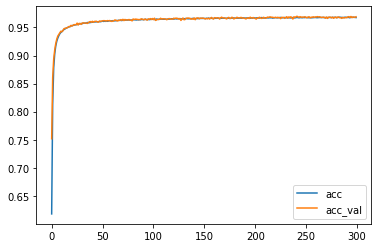

In [67]:
pd.DataFrame(history)[['acc','acc_val']].plot()

<AxesSubplot:>

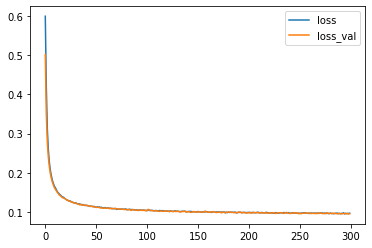

In [68]:
pd.DataFrame(history)[['loss','loss_val']].plot()

In [24]:
import time
from tqdm import tqdm
from collections import defaultdict
from itertools import chain
import pickle



def evaluate_link_pred(score_f,graph,entity_vec_mapping,entities,vector_size = 100, max_triples=100, plot = False):
    print('start_evaluating ...')
    
    entities = np.array(entities)
    
    stats = {'generate_time' : [],
        'convert_time:': [],
        'score_time': [],
        'sort_time': [],
        'total_time': []}

    ranks = []
    
    
    # slightly complicated defaultdict trick. Uninitialised 2dim matrix. 
    # Only store what was seen. Return None for other values

    embeddings_scores = defaultdict(lambda: defaultdict(lambda :None))

    
    graph = np.array(graph)
    
    if max_triples:
        graph = choose_many(graph,max_triples)
    
    
    for i,tp in enumerate(tqdm(np.array(graph))):
                                   
        s,p,o = tp
        start_timer = time.perf_counter()
        # construct corrupted triples

        triples_to_test = np.array([tp]+get_all_corrupted_triples(tp,entities))
        
        
        

        generate_timer = time.perf_counter()
        
        if p in embeddings_scores.keys():
            
            # init
            lookup = embeddings_scores[p]
            lookup_scores = []
            ix_to_score = []
            
            # find scores and triple not scored
            for j,ttt in enumerate(triples_to_test):
                s,p,o = ttt
                
                if (s,o) in lookup.keys():
                    l = lookup[(s,o)]
                    lookup_scores.append((l,j))
                else:

                    ix_to_score.append(j)
            #print(pd.DataFrame(triples_to_test[ix_to_score]))
            pd.DataFrame(triples_to_test[ix_to_score], columns = ['s','p','o']).to_feather(f'debug/not_found_{i}.feather')
            pd.DataFrame(lookup.keys(), columns = ['s','o']).to_feather(f'debug/keys_{i}.feather')
            pd.DataFrame([[len(lookup_scores),len(triples_to_test),len(lookup_scores)/len(triples_to_test)]], columns = ['n_looked_up','n','%']).to_feather(f'debug/stats_{i}.feather')
            
            print(f"looked up {len(lookup_scores)} of {len(triples_to_test)} triples")
            # score unscored triples
            triples_to_score = triples_to_test[ix_to_score]
            if len(triples_to_score) > 0:
                vectors_to_score = get_vectors_fast(triples_to_score,entity_vec_mapping,vector_size=vector_size)
                convert_timer = time.perf_counter()
                scores = score_f(vectors_to_score).numpy().squeeze()

                # add scores to lookup
                for ttt, score in zip(triples_to_score,scores):
                    s, _ ,o = tp
                    embeddings_scores[p][(s,o)] = score
            else:
                scores =[]
                
            score_timer = time.perf_counter()
            
            # combine scores

            
            scores =  lookup_scores + list(zip(scores,ix_to_score))
 
            scores = np.array(scores)

            # sort by score
            scores = scores[np.argsort(scores[:,0])]
            
            # get rank
            # look at col 1 (ix) and find original triple ix.
            
            rank = len(scores) - np.where(scores[:,1] == 0)[0][0]
            sort_timer = time.perf_counter()
            
           
            
            
            
                
        else:
            vectors_to_test = get_vectors_fast(triples_to_test,entity_vec_mapping,vector_size=vector_size)
            convert_timer = time.perf_counter()

                # score them
            scores = (score_f(vectors_to_test)).numpy().squeeze()
            
            for tp, score in zip(triples_to_test,scores):
                    s,p,o = tp
                    embeddings_scores[p][(s,o)] = score                        

            if plot:
                fig = plot_embeddings(vectors_to_test,scores)
                fig.show()

            score_timer = time.perf_counter()
            # sort them 
            sort_ix = np.argsort(scores ,axis=0)
            rank =  len(sort_ix) - np.where(sort_ix == 0)[0][0]
         
        
            sort_timer = time.perf_counter()

        

        stats['generate_time'].append(generate_timer - start_timer)
        stats['convert_time:'].append(convert_timer -  generate_timer)
        stats['score_time'].append(score_timer-convert_timer)
        stats['sort_time'].append(sort_timer-score_timer)
        stats['total_time'].append(sort_timer-start_timer)
        ranks.append(rank)
        
        if i % 100 == 0:
            print(np.mean(rank),'\n',{key: np.mean(value) for key,value in list(stats.items())[-100:]})
            pass
            
        
    stats =  {key: np.mean(value) for key,value in stats.items()}
    
    ranks = np.array(ranks)
    
    stats['MR'] = np.mean(ranks)
    stats['MRR'] = np.mean(1/(ranks))
    stats['HITS1'] = np.count_nonzero(ranks <= 1)
    stats['HITS3'] = np.count_nonzero(ranks <= 3)
    stats['HITS10'] = np.count_nonzero(ranks <= 10)
        
    return  ranks, stats, embeddings_scores
    
        
        
        


In [25]:
def get_all_s_o_tuples(entities):
    return [(s,o) for s in entities for o in entities] + [(o,s) for s in entities for o in entities]
    
    

In [26]:
def test_if_row_in_array(row,arr):
    return np.any(np.sum(arr == row,axis=1) == 3)

In [27]:
def get_filter(triples,graphs):
    # Too slow ... parallelize?! What else? Faster lookup? How?
    graphs = [np.array(g) for g in graphs]

    graphs = np.concatenate(graphs,axis=0)
    
    known_ix = []
    
    for i,tp in enumerate(triples):
        if test_if_row_in_array(tp,graphs):
            known_ix.append(i)
    return known_ix
    
    

In [28]:
def map_keyed_vectors(word_vectors, iterable):
    """
    for some reason faster than native call :O
    """
    return np.array(list(word_vectors.get_vector(x) for x in iterable))

In [48]:
import time
from sklearn.utils.extmath import cartesian
def evaluate_link_pred_fast(score_f,graph,entity_vec_mapping,entities,vector_size = 100, max_triples=100, plot = False, filter_by=None,verbose = True):
    
    
    
    stats = {'preprocessing_time' : -1,
        'embeddings_time': [],
        'rank_time': [],
        'find_rank_time':[],
        'ranks':[]
        }
    
    start_timer = time.perf_counter()
    predicates = np.array(list(set(graph.predicates())))
    
    graph = np.array(graph)
    
    
    print(f"evaluate LP on graph with {len(graph)} triples, {len(entities)} entities and {len(predicates)} predicates!")
    
    print(f"Starting preprocessing")
    embeddings_scores = defaultdict(lambda: defaultdict(lambda :None))
    
    
    
    s_o_combinations = cartesian((entities,entities))   
    # Why sort them?!
    subjects = s_o_combinations[:,0] # sorted(s_o_combinations[:,0])
    subject_embeddings = entity_vec_mapping(subjects)
    
    objects = s_o_combinations[:,1]  #sorted(s_o_combinations[:,1])
    object_embeddings = entity_vec_mapping(objects)
    
    no_triples_per_predicate=len(subjects)
    
    
    
    preprocessing_timer = time.perf_counter()
    
    stats['preprocessing_time'] = preprocessing_timer - start_timer
    
    print(f"Finished preprocessing")
    
    del s_o_combinations
    
    
    for p in tqdm(predicates):
        predicate_start_timer = time.perf_counter()
        
        
             
        predicate_embedding = entity_vec_mapping([p])
        predicate_column = np.repeat(predicate_embedding,no_triples_per_predicate).reshape(no_triples_per_predicate,vector_size)
        
        #return subject_embeddings,predicate_column,object_embeddings

        triple_embeddings = np.concatenate([subject_embeddings,predicate_column,object_embeddings],axis=1)
        
        
        predicate_embeddings_timer = time.perf_counter()
        
        del predicate_column

        

        scores = np.squeeze(score_f(triple_embeddings))
        
        del triple_embeddings
        
        
        sorted_ix = np.flip(np.argsort(scores))       
        scored_triples = np.stack([subjects,np.repeat(p,len(objects)),objects]).T   
        scored_triples = scored_triples[sorted_ix]
        
        
        predicate_rank_timer = time.perf_counter()
        
        ranks = []
    

        predicate_subgraph = graph[graph[:,1] == p]
    
        for triple in predicate_subgraph:
            try:
                rank = np.where(np.sum(scored_triples ==triple,axis=1) == 3)[0][0]
                print(rank)
                ranks.append(rank)
            except:
                print(triple)
                print(np.where(np.sum(scored_triples ==triple,axis=1)))
                print('unknown entity or relation!')
                
        
        
        predicate_find_rank = time.perf_counter()
        
            
        stats['embeddings_time'].append(predicate_embeddings_timer-predicate_start_timer)
        stats['rank_time'].append(predicate_rank_timer - predicate_embeddings_timer)
        stats['find_rank_time'].append(predicate_find_rank - predicate_rank_timer)
        stats['ranks'].extend(ranks)
        
       
        

    return  stats

In [69]:
from rdflib import Graph, URIRef
from rdflib.extras.external_graph_libs import rdflib_to_networkx_multidigraph
import networkx as nx



g_train = Graph()
g_val = Graph()
g_test = Graph()

g_train = g_train.parse('FB15k-237/train_100.nt', format='nt')
g_val   = g_val.parse('FB15k-237/valid_100.nt', format='nt')
g_test  = g_test.parse('FB15k-237/test_100.nt', format='nt')


# clean graphs 
# number of triples removed should be low, a few hundred
print(f"removed {clean_graph(g_train,word_vectors)} triples from training set")
print(f"removed {clean_graph(g_val,word_vectors)} triples from validation set")
print(f"removed {clean_graph(g_test,word_vectors)} triples from test set")

entities = get_entities((g_train,g_val,g_test))

removed 0 triples from training set
removed 0 triples from validation set
removed 0 triples from test set


In [ ]:
with torch.no_grad():
    stats = evaluate_link_pred_fast(lambda x : model.predict_numpy(x), g_test, lambda x : word_vectors[x], entities, max_triples=None)   

evaluate LP on graph with 100 triples, 529 entities and 45 predicates!
Starting preprocessing
Finished preprocessing


  2%|██▏                                                                                             | 1/45 [00:00<00:29,  1.48it/s]

121449
47002


  4%|████▎                                                                                           | 2/45 [00:01<00:27,  1.55it/s]

83161
7489


  7%|██████▍                                                                                         | 3/45 [00:01<00:26,  1.57it/s]

33892
63644


In [45]:
529**2

279841

In [47]:
len(stats['ranks'])

100

# Plot the embeddings 

In [33]:
X, Y = get_1_1_dataset(g_train,entities,lambda x : word_vectors[x],corrupt='both')
#x_val , y_val= get_1_1_dataset(g_val,entities,lambda x : word_vectors[x])
#x_test , y_test= get_1_1_dataset(g_test,entities,lambda x : word_vectors[x])

x,y = X, Y
#for x,y in [(X,Y),(x_val,y_val),(x_test,y_test)]:
    

In [34]:
import sklearn.manifold
import pandas as pd
import plotly.express as px

reduction_model = sklearn.manifold.TSNE(learning_rate='auto',init='pca').fit_transform

In [35]:
def plot_embeddings(x,y,reduction_model=sklearn.manifold.TSNE(learning_rate='auto',init='pca').fit_transform,number_of_examples=10000):
"""
x = multi dim array (SAMPLES,EMBEDDING_DIM)
y = one-dim array (SAMPLES,)
"""
    x,y = choose_many_multiple([x,y],number_of_examples)
    x_reduced=reduction_model(x)

    plot_data = np.concatenate((x_reduced,np.expand_dims(y,1)),1)

    df = pd.DataFrame(plot_data,columns=list(range(x_tsne.shape[1]))+['label'])


    fig = px.scatter(df, x=0, y=1, color="label")
    return fig

IndentationError: expected an indented block after function definition on line 1 (559729533.py, line 2)

In [ ]:
Y.shape

In [ ]:
X, Y = get_1_1_dataset(g_train,entities,lambda x : word_vectors[x],corrupt='both')

plot_embeddings(X,Y)

In [ ]:
X, Y = get_1_1_dataset(g_train,entities,lambda x : word_vectors[x],corrupt='subject')
plot_embeddings(X,Y)

In [ ]:
X, Y = get_1_1_dataset(g_train,entities,lambda x : word_vectors[x],corrupt='object')
plot_embeddings(X,Y)

## Get walks into ram :)